In [ ]:
!pip install pandas

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
import xgboost as xgb
import missingno as msno

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("/content/drive/My Drive/Loan_Default_Prediction/Data")
#点击下方连接，得到授权码，输入到下方空白栏出，授权使用云盘中的数据

Mounted at /content/drive


In [34]:
train_data = pd.read_csv('./train.csv', sep = ',')
test_data = pd.read_csv('./testA.csv', sep = ',')

In [ ]:
train_data.head()

id  loanAmnt  term  interestRate  installment  ...   n10  n11  n12  n13  n14
0   0   35000.0     5         19.52       917.97  ...   7.0  0.0  0.0  0.0  2.0
1   1   18000.0     5         18.49       461.90  ...  13.0  NaN  NaN  NaN  NaN
2   2   12000.0     5         16.99       298.17  ...  11.0  0.0  0.0  0.0  4.0
3   3   11000.0     3          7.26       340.96  ...   9.0  0.0  0.0  0.0  1.0
4   4    3000.0     3         12.99       101.07  ...  12.0  0.0  0.0  0.0  4.0

[5 rows x 47 columns]

## 1.EDA 

In [ ]:
train_data.shape
test_data.shape

(200000, 48)

In [ ]:
train_data.columns

Index(['id', 'loanAmnt', 'term', 'interestRate', 'installment', 'grade',
       'subGrade', 'employmentTitle', 'employmentLength', 'homeOwnership',
       'annualIncome', 'verificationStatus', 'issueDate', 'isDefault',
       'purpose', 'postCode', 'regionCode', 'dti', 'delinquency_2years',
       'ficoRangeLow', 'ficoRangeHigh', 'openAcc', 'pubRec',
       'pubRecBankruptcies', 'revolBal', 'revolUtil', 'totalAcc',
       'initialListStatus', 'applicationType', 'earliesCreditLine', 'title',
       'policyCode', 'n0', 'n1', 'n2', 'n2.1', 'n4', 'n5', 'n6', 'n7', 'n8',
       'n9', 'n10', 'n11', 'n12', 'n13', 'n14'],
      dtype='object')

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800000 entries, 0 to 799999
Data columns (total 47 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  800000 non-null  int64  
 1   loanAmnt            800000 non-null  float64
 2   term                800000 non-null  int64  
 3   interestRate        800000 non-null  float64
 4   installment         800000 non-null  float64
 5   grade               800000 non-null  object 
 6   subGrade            800000 non-null  object 
 7   employmentTitle     799999 non-null  float64
 8   employmentLength    753201 non-null  object 
 9   homeOwnership       800000 non-null  int64  
 10  annualIncome        800000 non-null  float64
 11  verificationStatus  800000 non-null  int64  
 12  issueDate           800000 non-null  object 
 13  isDefault           800000 non-null  int64  
 14  purpose             800000 non-null  int64  
 15  postCode            799999 non-nul

In [ ]:
train_data['employmentTitle'].value_counts()

54.0        51149
38.0        12644
32.0        11543
184.0        6112
151.0        5193
            ...  
311225.0        1
13438.0         1
311224.0        1
311223.0        1
269398.0        1
Name: employmentTitle, Length: 248683, dtype: int64

In [ ]:
train_data['term'].value_counts()

3    606902
5    193098
Name: term, dtype: int64

### 1.1特征分类

In [35]:

# employmentTitle 可以用数据类型特征/分箱后作为分类类型特征,暂时用前者方法处理
# issueDate 日期类型信息
# earliesCreditLine 可转为日期类型信息
feature_columns = ['loanAmnt', 'term', 'interestRate', 'installment', 'grade',
       'subGrade', 'employmentTitle', 'employmentLength', 'homeOwnership',
       'annualIncome', 'verificationStatus', 'issueDate', 
       'purpose', 'postCode', 'regionCode', 'dti', 'delinquency_2years',
       'ficoRangeLow', 'ficoRangeHigh', 'openAcc', 'pubRec',
       'pubRecBankruptcies', 'revolBal', 'revolUtil', 'totalAcc',
       'initialListStatus', 'applicationType', 'earliesCreditLine', 'title',
       'policyCode', 'n0', 'n1', 'n2', 'n2.1', 'n4', 'n5', 'n6', 'n7', 'n8',
       'n9', 'n10', 'n11', 'n12', 'n13', 'n14']      


numerical_fea = ['loanAmnt', 'term', 'interestRate', 'installment', 
        'employmentTitle',  'annualIncome',  'issueDate', 
        'postCode', 'regionCode', 'dti', 'delinquency_2years',
       'ficoRangeLow', 'ficoRangeHigh', 'openAcc', 'pubRec',
       'pubRecBankruptcies', 'revolBal', 'revolUtil', 'totalAcc',
       'initialListStatus', 'applicationType', 'earliesCreditLine', 'title',
       'policyCode', 'n0', 'n1', 'n2', 'n2.1', 'n4', 'n5', 'n6', 'n7', 'n8',
       'n9', 'n10', 'n11', 'n12', 'n13', 'n14']
categorical_fea = ['grade','subGrade','employmentLength','homeOwnership','verificationStatus','purpose']

num_fea = list(train_data.select_dtypes(exclude=['object']).columns)
cat_fea = list(filter(lambda x: x not in numerical_fea,feature_columns))
# num_fea = ['loanAmnt', 'term', 'interestRate', 'installment', 'employmentTitle', 'homeOwnership',
#        'annualIncome', 'verificationStatus',
#        'purpose', 'postCode', 'regionCode', 'dti', 'delinquency_2years',
#        'ficoRangeLow', 'ficoRangeHigh', 'openAcc', 'pubRec',
#        'pubRecBankruptcies', 'revolBal', 'revolUtil', 'totalAcc',
#        'initialListStatus', 'applicationType', 'title',
#        'policyCode', 'n0', 'n1', 'n2', 'n2.1', 'n4', 'n5', 'n6', 'n7', 'n8',
#        'n9', 'n10', 'n11', 'n12', 'n13', 'n14']
# cat_fea = ['grade','subGrade','employmentLength',]       
X_data = train_data[feature_columns]
Y_data = train_data['isDefault']

### 1.2数据分布

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


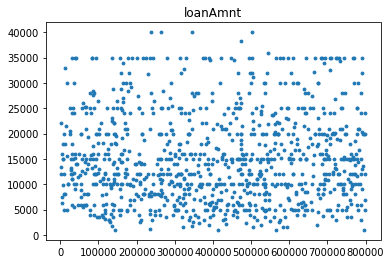

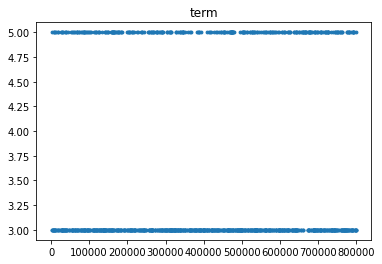

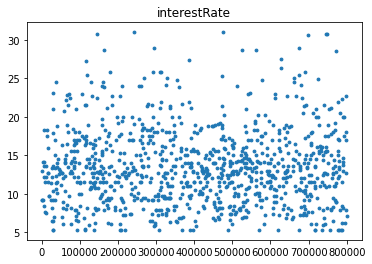

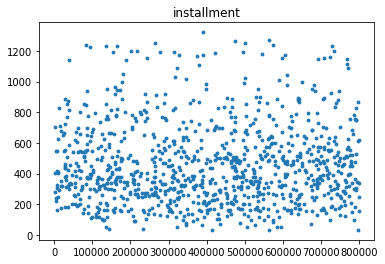

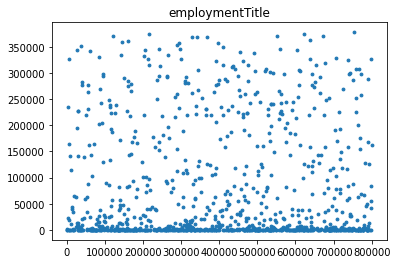

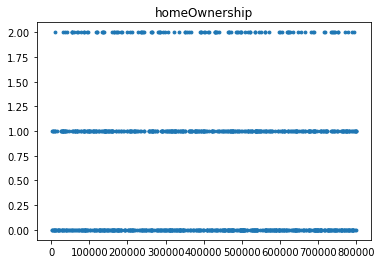

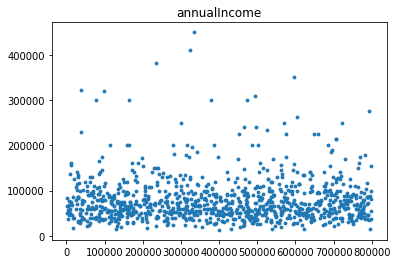

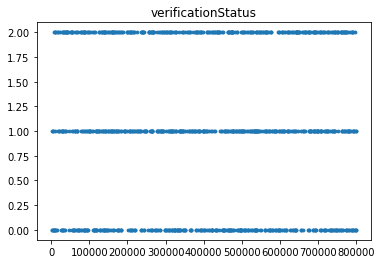

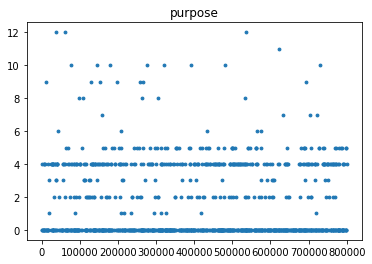

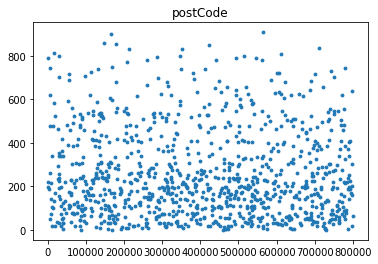

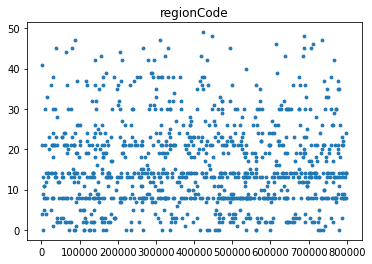

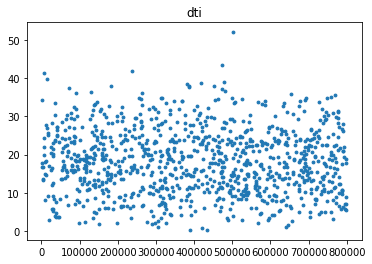

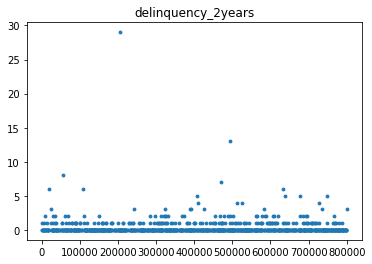

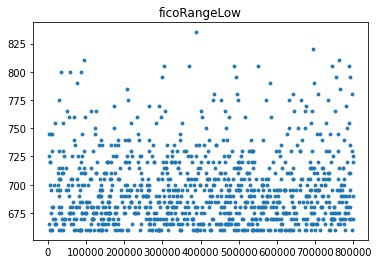

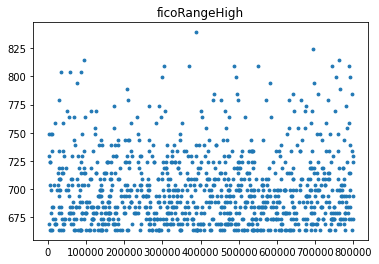

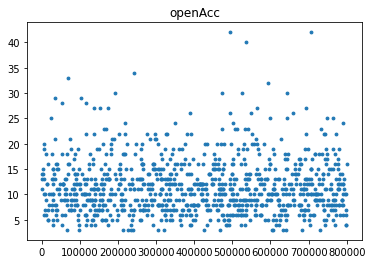

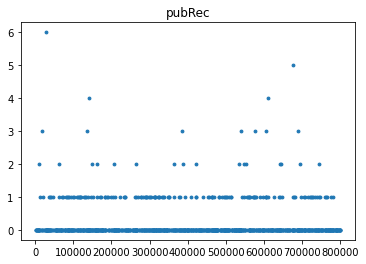

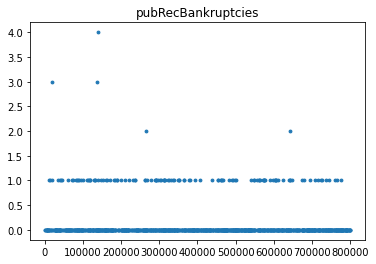

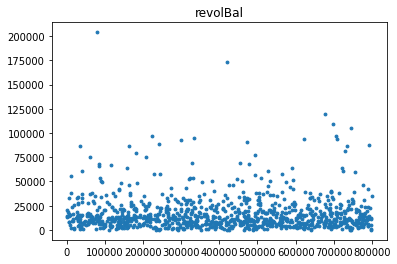

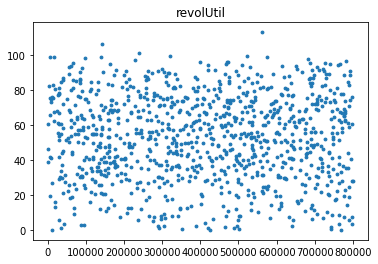

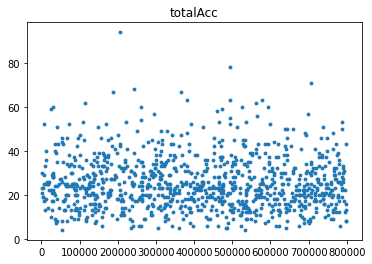

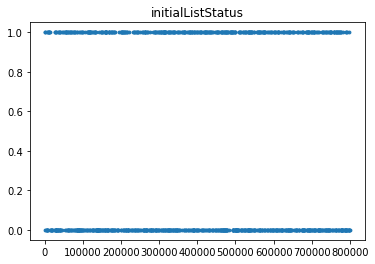

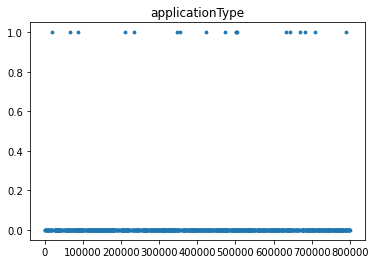

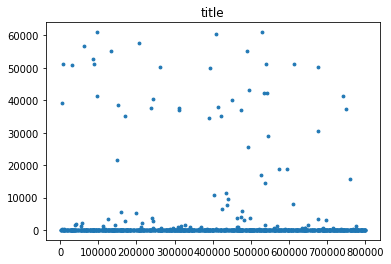

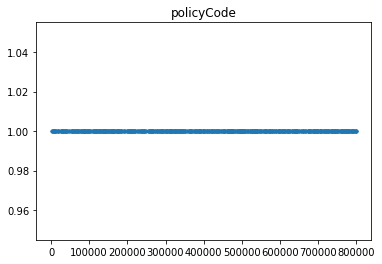

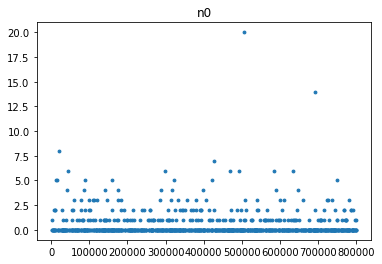

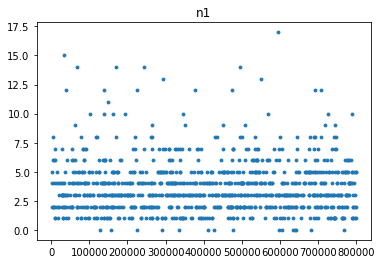

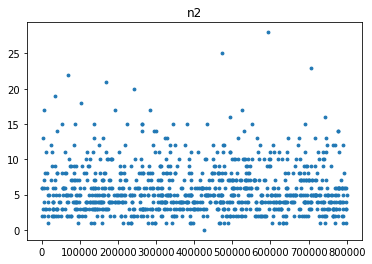

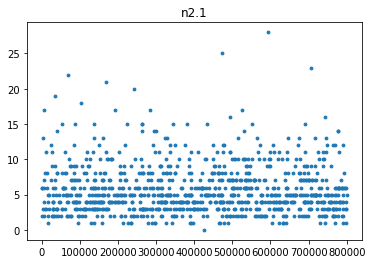

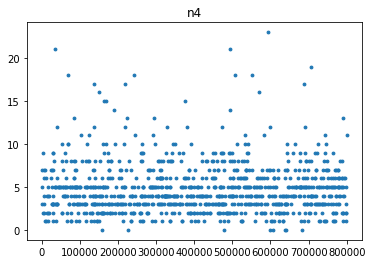

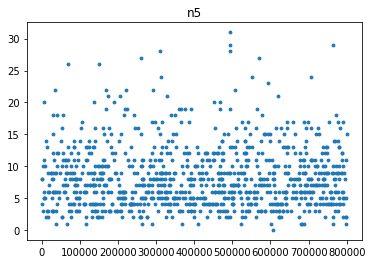

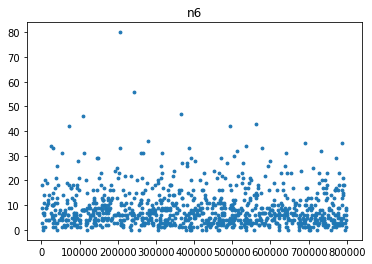

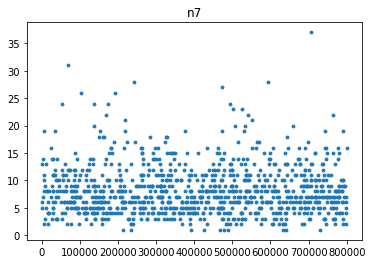

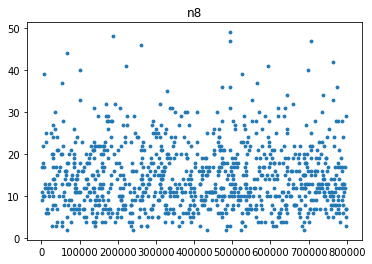

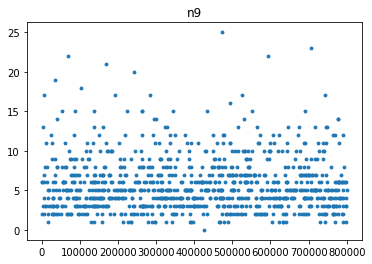

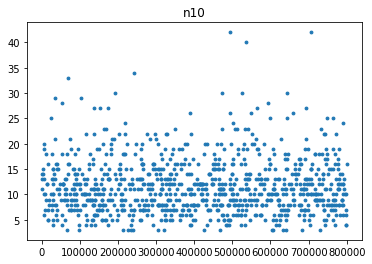

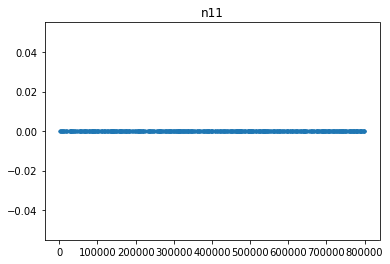

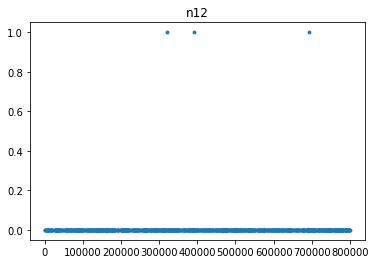

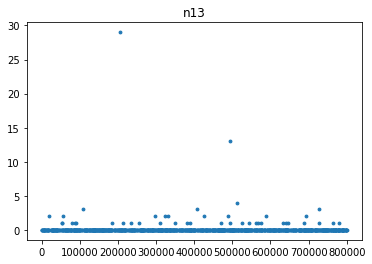

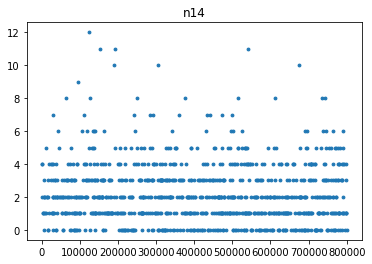

In [ ]:
sample = train_data.sample(1000)
# 查看Numerical features的分布情况，离散还是连续
for feas in num_fea:
  plt.figure(figsize = (6,4))
  plt.title(feas)
  plt.scatter(sample['id'], sample[feas], s = 8)



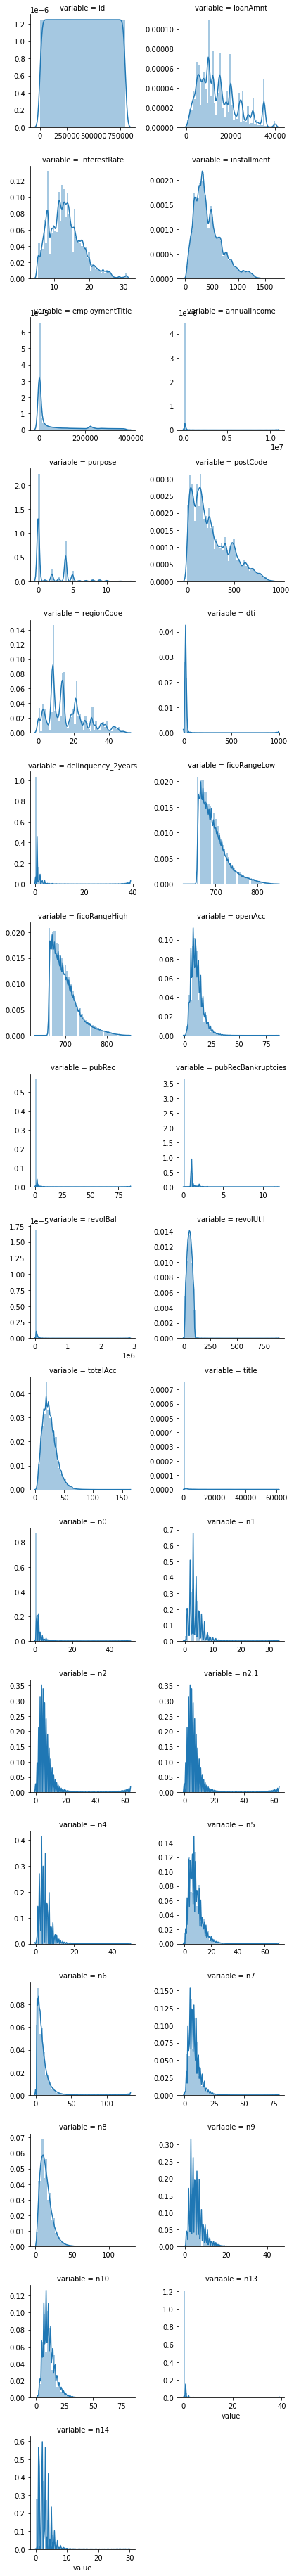

In [ ]:
#过滤数值型类别特征
def get_numerical_serial_fea(data,feas):
    numerical_serial_fea = []
    numerical_noserial_fea = []
    for fea in feas:
        temp = data[fea].nunique()
        if temp <= 10:
            numerical_noserial_fea.append(fea)
            continue
        numerical_serial_fea.append(fea)
    return numerical_serial_fea,numerical_noserial_fea
numerical_serial_fea,numerical_noserial_fea = get_numerical_serial_fea(train_data,num_fea)

#每个数字特征得分布可视化
f = pd.melt(train_data, value_vars=numerical_serial_fea)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")

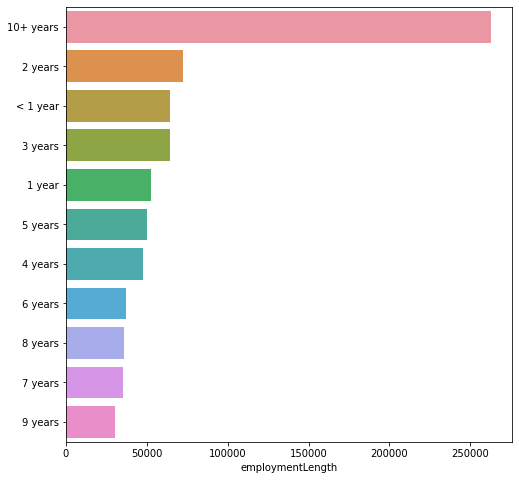

In [ ]:
# 变量分布可视化
plt.figure(figsize=(8, 8))
sns.barplot(train_data["employmentLength"].value_counts(dropna=False)[:20],
            train_data["employmentLength"].value_counts(dropna=False).keys()[:20])
plt.show()

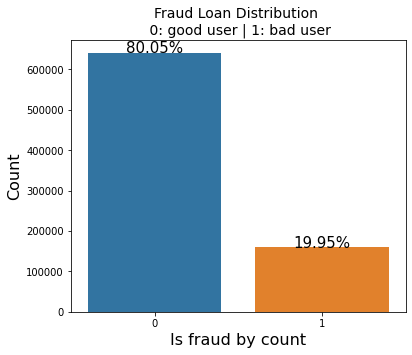

In [ ]:
# 正负样本比例
total = len(train_data)
total_amt = train_data.groupby(['isDefault'])['loanAmnt'].sum().sum()
plt.figure(figsize=(6,5))
plot_tr = sns.countplot(x='isDefault',data=train_data)#train data‘isDefault’这个特征每种类别的数量**
plot_tr.set_title("Fraud Loan Distribution \n 0: good user | 1: bad user", fontsize=14)
plot_tr.set_xlabel("Is fraud by count", fontsize=16)
plot_tr.set_ylabel('Count', fontsize=16)
for p in plot_tr.patches:
    height = p.get_height()
    plot_tr.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=15) 

In [ ]:
pivot = pd.pivot_table(train_data, index=['grade'], columns=['issueDateDT'], values=['loanAmnt'], aggfunc=np.sum)

In [ ]:
pivot

loanAmnt                    ...                                 
issueDateDT     0        30       61    ...       4140       4171       4201
grade                                   ...                                 
A                NaN  53650.0  42000.0  ...  3919275.0  2694025.0  2245625.0
B                NaN  13000.0  24000.0  ...  4329400.0  3922575.0  3257100.0
C                NaN  68750.0   8175.0  ...  4552600.0  2870050.0  2246250.0
D                NaN      NaN   5500.0  ...  3038500.0  2452375.0  1771750.0
E             7500.0      NaN  10000.0  ...  1131625.0   883950.0   802425.0
F                NaN      NaN  31250.0  ...   315075.0    72300.0        NaN
G                NaN      NaN      NaN  ...    23750.0    25100.0     1000.0

[7 rows x 139 columns]

### 1.3缺失值

In [ ]:
train_data.isnull().sum()

id                        0
loanAmnt                  0
term                      0
interestRate              0
installment               0
grade                     0
subGrade                  0
employmentTitle           1
employmentLength      46799
homeOwnership             0
annualIncome              0
verificationStatus        0
issueDate                 0
isDefault                 0
purpose                   0
postCode                  1
regionCode                0
dti                     239
delinquency_2years        0
ficoRangeLow              0
ficoRangeHigh             0
openAcc                   0
pubRec                    0
pubRecBankruptcies      405
revolBal                  0
revolUtil               531
totalAcc                  0
initialListStatus         0
applicationType           0
earliesCreditLine         0
title                     1
policyCode                0
n0                    40270
n1                    40270
n2                    40270
n2.1                

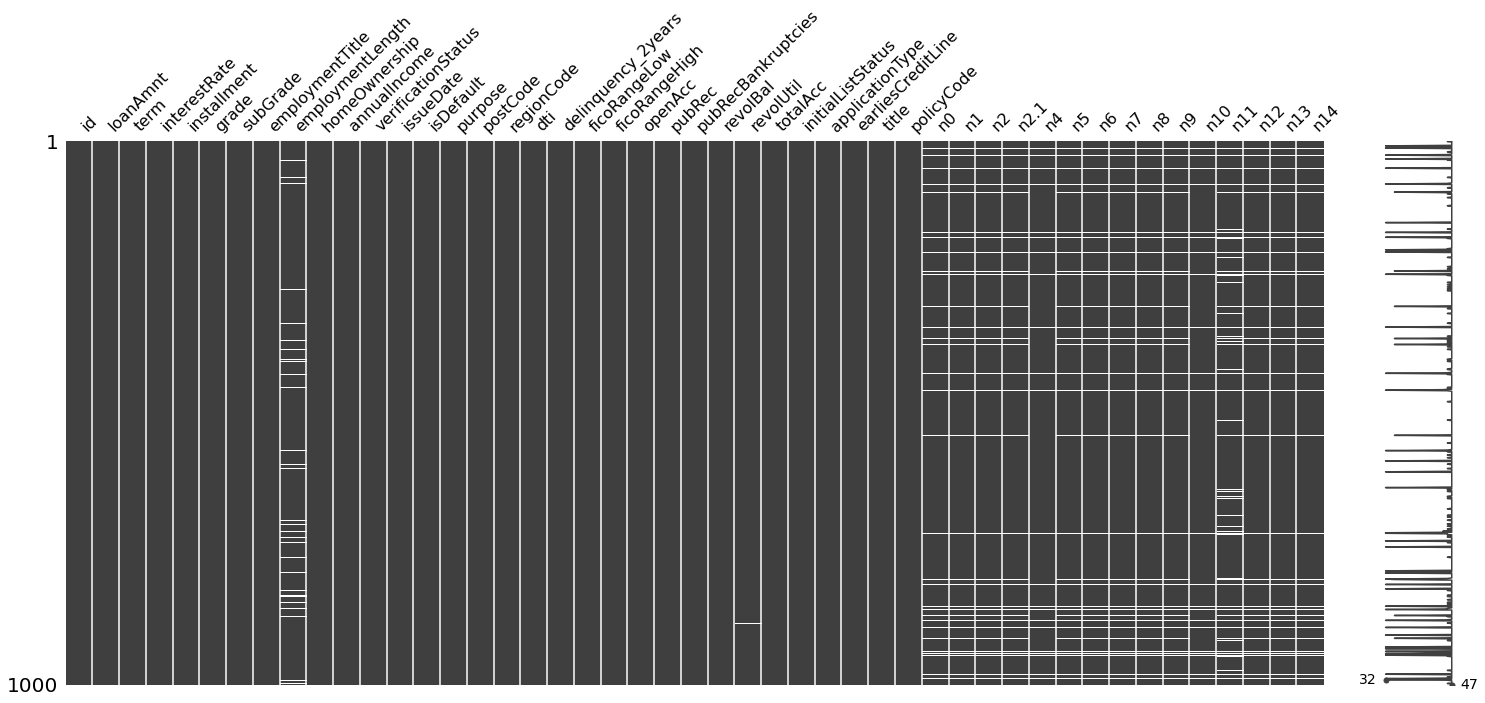

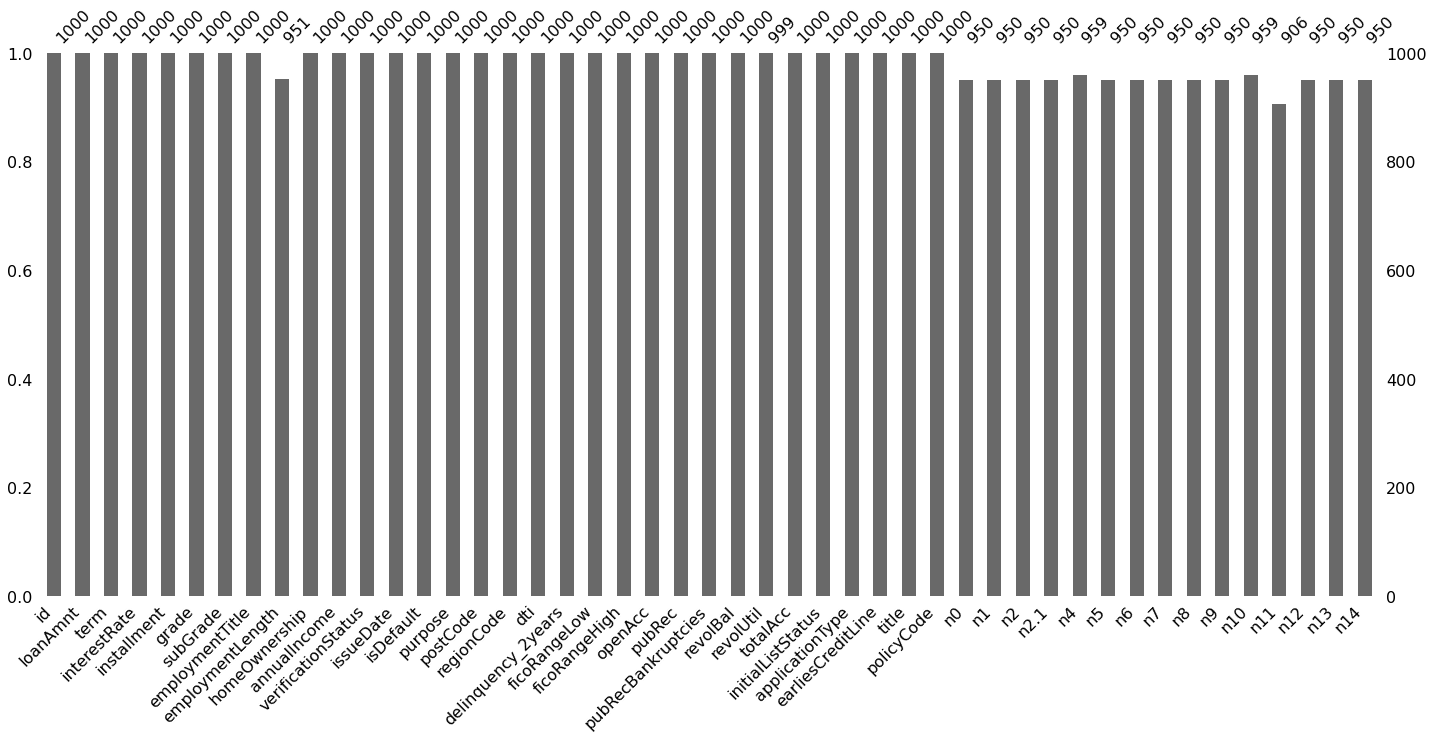

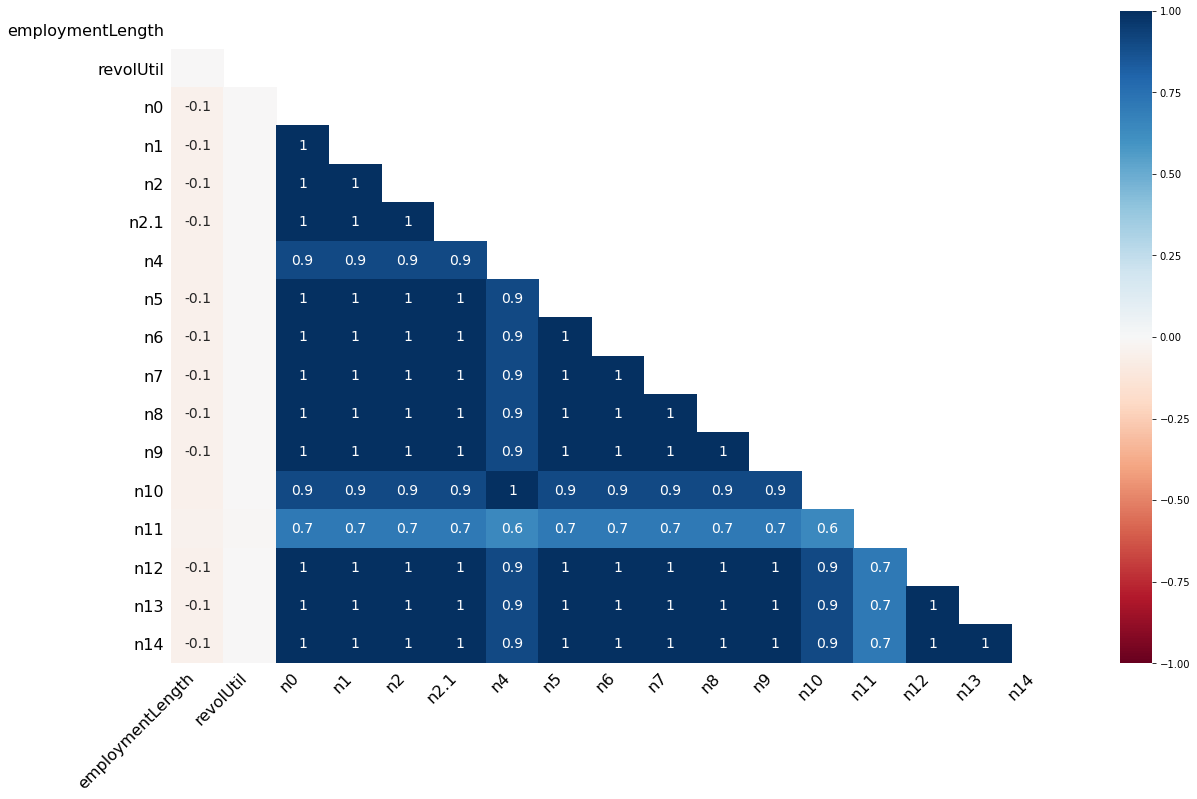

In [ ]:
sample = train_data.sample(1000)
msno.matrix(sample)
plt.show()
msno.bar(sample)
plt.show()
msno.heatmap(sample)
plt.show()

## 2.特征工程

### 2.1 时间格式处理

In [43]:
import datetime
# issueDate 转换为数值
train_data['issueDate'] = pd.to_datetime(train_data['issueDate'],format='%Y-%m-%d')
startdate = datetime.datetime.strptime('2007-06-01', '%Y-%m-%d')
train_data['issueDateDT'] = train_data['issueDate'].apply(lambda x: x-startdate).dt.days

In [44]:
test_data['issueDate'] = pd.to_datetime(test_data['issueDate'],format='%Y-%m-%d')
startdate = datetime.datetime.strptime('2007-06-01', '%Y-%m-%d')
test_data['issueDateDT'] = test_data['issueDate'].apply(lambda x: x-startdate).dt.days

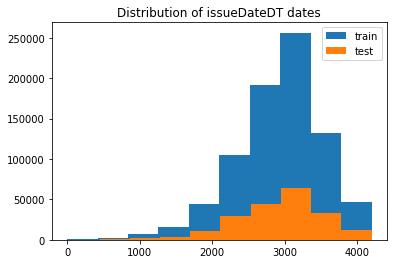

In [31]:
plt.hist(train_data['issueDateDT'], label='train');
plt.hist(test_data['issueDateDT'], label='test');
plt.legend();
plt.title('Distribution of issueDateDT dates');

In [45]:
train_data.head()

id  loanAmnt  ...  earliesCreditLine_dateDT  issueDateDT
0   0   35000.0  ...                     18840         2587
1   1   18000.0  ...                     19113         1888
2   2   12000.0  ...                     20574         3044
3   3   11000.0  ...                     18017         2983
4   4    3000.0  ...                     10074         3196

[5 rows x 49 columns]

In [36]:
# earliesCreditLine 转为日期类型
dic_month = {'Jan':'01', 'Feb':'02', 'Mar':'03', 'Apr':'04', 'May':'05', 'Jun':'06', 'Jul':'07', 'Aug':'08', 'Sep':'09', 'Oct':'10', 'Nov':'11', 'Dec':'12'}

def get_month_year(str):
  month = list(str)[0] + list(str)[1] + list(str)[2]
  month = dic_month[month]
  year = list(str)[-4] + list(str)[-3] + list(str)[-2] + list(str)[-1]
  date = year + '-' + month + '-' + '01'
  return date


train_data['earliesCreditLine_date'] = train_data['earliesCreditLine'].apply(lambda x : get_month_year(x))
test_data['earliesCreditLine_date'] = test_data['earliesCreditLine'].apply(lambda x : get_month_year(x))
train_data = train_data.drop(columns = 'earliesCreditLine')
test_data = test_data.drop(columns = 'earliesCreditLine')

In [39]:
# earliesCreditLine_date 转换为数值(时间差)
train_data['earliesCreditLine_date'] = pd.to_datetime(train_data['earliesCreditLine_date'],format='%Y-%m-%d')
startdate = datetime.datetime.strptime('1950-01-01', '%Y-%m-%d')
train_data['earliesCreditLine_dateDT'] = train_data['earliesCreditLine_date'].apply(lambda x: x-startdate).dt.days

In [40]:
test_data['earliesCreditLine_date'] = pd.to_datetime(test_data['earliesCreditLine_date'],format='%Y-%m-%d')
startdate = datetime.datetime.strptime('1950-01-01', '%Y-%m-%d')
test_data['earliesCreditLine_dateDT'] = test_data['earliesCreditLine_date'].apply(lambda x: x-startdate).dt.days

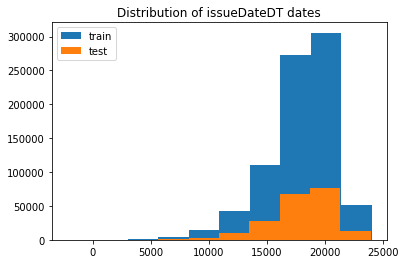

In [41]:
plt.hist(train_data['earliesCreditLine_dateDT'], label='train');
plt.hist(test_data['earliesCreditLine_dateDT'], label='test');
plt.legend();
plt.title('Distribution of issueDateDT dates');

In [26]:
train_data.head()

id  loanAmnt  ...  earliesCreditLine_year  earliesCreditLine_date
0   0   35000.0  ...                    2001              2001-08-01
1   1   18000.0  ...                    2002              2002-05-01
2   2   12000.0  ...                    2006              2006-05-01
3   3   11000.0  ...                    1999              1999-05-01
4   4    3000.0  ...                    1977              1977-08-01

[5 rows x 51 columns]

In [47]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800000 entries, 0 to 799999
Data columns (total 49 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   id                        800000 non-null  int64         
 1   loanAmnt                  800000 non-null  float64       
 2   term                      800000 non-null  int64         
 3   interestRate              800000 non-null  float64       
 4   installment               800000 non-null  float64       
 5   grade                     800000 non-null  object        
 6   subGrade                  800000 non-null  object        
 7   employmentTitle           799999 non-null  float64       
 8   employmentLength          753201 non-null  object        
 9   homeOwnership             800000 non-null  int64         
 10  annualIncome              800000 non-null  float64       
 11  verificationStatus        800000 non-null  int64         
 12  is

In [64]:

# employmentTitle 可以用数据类型特征/分箱后作为分类类型特征,暂时用前者方法处理
# issueDate 日期类型信息
# earliesCreditLine 可转为日期类型信息
# policycode，n11 几乎只有一种取值，drop
feature_columns = ['loanAmnt', 'term', 'interestRate', 'installment', 'grade',
       'subGrade', 'employmentTitle', 'employmentLength', 'homeOwnership',
       'annualIncome', 'verificationStatus', 
       'purpose', 'postCode', 'regionCode', 'dti', 'delinquency_2years',
       'ficoRangeLow', 'ficoRangeHigh', 'openAcc', 'pubRec',
       'pubRecBankruptcies', 'revolBal', 'revolUtil', 'totalAcc',
       'initialListStatus', 'applicationType',  'title',
      'n0', 'n1', 'n2', 'n2.1', 'n4', 'n5', 'n6', 'n7', 'n8',
       'n9', 'n10', 'n12', 'n13', 'n14','issueDateDT','earliesCreditLine_dateDT']      


numerical_fea = ['loanAmnt', 'term', 'interestRate', 'installment', 
        'employmentTitle',  'annualIncome',  
        'postCode', 'regionCode', 'dti', 'delinquency_2years',
       'ficoRangeLow', 'ficoRangeHigh', 'openAcc', 'pubRec',
       'pubRecBankruptcies', 'revolBal', 'revolUtil', 'totalAcc',
       'initialListStatus', 'applicationType',  'title',
        'n0', 'n1', 'n2', 'n2.1', 'n4', 'n5', 'n6', 'n7', 'n8',
       'n9', 'n10', 'n12', 'n13', 'n14', 'issueDateDT', 'earliesCreditLine_dateDT']
categorical_fea = ['grade','subGrade','employmentLength','homeOwnership','verificationStatus','purpose']

num_fea = list(train_data.select_dtypes(exclude=['object']).columns)
cat_fea = list(filter(lambda x: x not in numerical_fea,feature_columns))
# num_fea = ['loanAmnt', 'term', 'interestRate', 'installment', 'employmentTitle', 'homeOwnership',
#        'annualIncome', 'verificationStatus',
#        'purpose', 'postCode', 'regionCode', 'dti', 'delinquency_2years',
#        'ficoRangeLow', 'ficoRangeHigh', 'openAcc', 'pubRec',
#        'pubRecBankruptcies', 'revolBal', 'revolUtil', 'totalAcc',
#        'initialListStatus', 'applicationType', 'title',
#        'policyCode', 'n0', 'n1', 'n2', 'n2.1', 'n4', 'n5', 'n6', 'n7', 'n8',
#        'n9', 'n10', 'n11', 'n12', 'n13', 'n14']
# cat_fea = ['grade','subGrade','employmentLength',]       


### 2.2类别特征 label encoding

In [53]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
le = LabelEncoder()
train_data['grade'] = le.fit_transform(train_data['grade'])
train_data['subGrade'] = le.fit_transform(train_data['subGrade'])
train_data['employmentLength'] = train_data['employmentLength'].apply(lambda x : str(x))
train_data['employmentLength'] = le.fit_transform(train_data['employmentLength'])
test_data['grade'] = le.fit_transform(test_data['grade'])
test_data['subGrade'] = le.fit_transform(test_data['subGrade'])
test_data['employmentLength'] = test_data['employmentLength'].apply(lambda x : str(x))
test_data['employmentLength'] = le.fit_transform(test_data['employmentLength'])

In [55]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800000 entries, 0 to 799999
Data columns (total 49 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   id                        800000 non-null  int64         
 1   loanAmnt                  800000 non-null  float64       
 2   term                      800000 non-null  int64         
 3   interestRate              800000 non-null  float64       
 4   installment               800000 non-null  float64       
 5   grade                     800000 non-null  int64         
 6   subGrade                  800000 non-null  int64         
 7   employmentTitle           799999 non-null  float64       
 8   employmentLength          800000 non-null  int64         
 9   homeOwnership             800000 non-null  int64         
 10  annualIncome              800000 non-null  float64       
 11  verificationStatus        800000 non-null  int64         
 12  is

In [71]:
X_data = train_data[feature_columns]
Y_data = train_data['isDefault']
X_test = test_data[feature_columns]

## 3.模型使用

### 3.1树模型融合

In [66]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
#data 划分
x_train, x_val, y_train, y_val = train_test_split(X_data, Y_data, test_size = 0.2)
#x_train, x_val, y_train, y_val = train_test_split(X_data, np.log(Y_data), test_size = 0.2)

In [67]:
import xgboost as xgb
def build_model_xgb(x_train, y_train):
    model = xgb.XGBRegressor(n_estimators = 150, learning_rate = 0.1, gama = 0, max_depth = 7)
    model.fit(x_train, y_train)
    return model

import lightgbm as lgb
def build_model_lgb(x_train, y_train):
    model = lgb.LGBMRegressor(n_estimator = 150, num_leaves = 127, learning_rate = 0.1)
    model.fit(x_train, y_train)
    return model

from sklearn.ensemble import RandomForestRegressor
def build_model_rf(x_train, y_train):
    model = RandomForestRegressor(n_estimators = 150, max_depth = 6, max_features = 'sqrt', criterion = 'mae')
    model.fit(x_train, y_train)
    return model


xgoost

In [77]:
model_xgb = build_model_xgb(x_train, y_train)
val_xgb = model_xgb.predict(x_val)
AUC_xgb = roc_auc_score(y_val, val_xgb)
print('xgboost validation AUC', AUC_xgb)

[13:55:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


KeyboardInterrupt: ignored

In [76]:
# model_xgb2 = build_model_xgb(X_data, np.log(Y_data))
# result_xgb = model_xgb2.predict(X_test)
# result_xgb = np.exp(result_xgb)
model_xgb2 = build_model_xgb(X_data, Y_data)
result_xgb = model_xgb2.predict(X_test)

[13:38:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


LightGBM

In [69]:
model_lgb = build_model_lgb(x_train, y_train)
val_lgb = model_lgb.predict(x_val)
AUC_lgb = roc_auc_score(y_val, val_lgb)
print('lightGBM validation AUC', AUC_lgb)

lightGBM validation AUC 0.7327397721650026


In [72]:
model_lgb2 = build_model_lgb(X_data, Y_data)
result_lgb = model_lgb2.predict(X_test)

Ensemble

In [ ]:
import matplotlib.pyplot as plt
AUC_sum = AUC_xgb + AUC_lgb
predict_y = (1-AUC_lgb/AUC_sum) * result_lgb + (1-AUC_xgb/AUC_sum) * result_xgb
plt.hist(predict_y)
plt.show()

## End:输出结果

In [74]:
predict_y = result_lgb

In [75]:
# 输出结果
sub = pd.DataFrame()
sub['id'] = test_data.id
sub['isDefault'] = predict_y
#sub['price'] = np.exp(predict_y)
sub.to_csv('./result.csv', index = False)